<a href="https://colab.research.google.com/github/croco22/CapstoneProjectTDS/blob/main/notebooks/03_Dataset_Continuous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extra Task 1: Continuous Dataset Evaluation
In this step, several questions will be answered at once in order to increase the complexity for the model. By introducing multiple questions in a single request, we aim to test how well the model handles and responds to more complex inputs, simulating a real-world scenario where users may provide multiple queries in one interaction.

The secrets `GOOGLE_API_KEY` and `HF_TOKEN` must be configured in your Colab environment for proper execution.

## Imports and Setup

In [1]:
%%capture
!pip install dateparser
!pip install fuzzywuzzy
!pip install word2number

import random
import re
import time

import dateparser
import google.generativeai as genai
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz
from google.colab import userdata
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    jaccard_score,
    precision_score,
    recall_score,
)
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from word2number import w2n

In [2]:
# API setup
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
model = genai.GenerativeModel('gemini-2.0-flash-exp')
userdata.get('HF_TOKEN')


def generate_text(prompt):
    """
    Generates text based on the provided prompt using the genai model. The function sends the prompt
    to the model, with a generation configuration that includes a temperature of 2.0 for creative output.
    It then waits for 5 seconds to avoid exceeding API limits before returning the generated text.
    """
    try:
        response = model.generate_content(
            prompt,
            generation_config=genai.GenerationConfig(
                temperature=2.0, # creative output
            )
        )
        time.sleep(10) # avoid exceeding API limits
        return response.text.strip()
    except Exception as e:
        exit("Error during API call: ", e)

In [3]:
url = 'https://raw.githubusercontent.com/croco22/CapstoneProjectTDS/refs/heads/main/qa_dataset.json'
data = pd.read_json(url)

data.head()

,type,question,options,intended_answer,context,timestamp
0,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Absolutely, you've got my consent for that dat...",2025-01-29 13:37:12.404
1,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Yes, you can absolutely process my data, that'...",2025-01-29 13:37:12.404
2,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Without any hesitation, I can confirm yes, tha...",2025-01-29 13:37:12.404
3,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Okay then, for that question regarding data pr...",2025-01-29 13:37:12.404
4,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"That sounds perfectly fine to me, I wholeheart...",2025-01-29 13:37:12.404


## Continuous Text Generation
To generate a coherent text, three questions are grouped together. Since combining multiple questions with phone numbers or dates wouldn't make much sense (because the scenario would be very unrealistic) a random pre-selection is made, where only one number and one date entry are included. Additionally, three random single- and multi-select questions are added. From this set of eight questions, three are randomly selected and then combined into a text.

Previously, we tested a **text summarization model from Hugging Face** for this task. However, the performance was quite poor. When the output length was too long, it did not summarize the content but rather just appended the text. On the other hand, when the output length was too short, important elements of the response were omitted.

In [4]:
prompt = """
    Summarize the following text that answers different questions, which may
    not necessarily be related to the same context. The summary should provide
    a concise version of the text, ensuring that key details and answer
    components are preserved without simply appending or omitting important
    information. Return only the summarized answer text, without quotation marks.
    Text:
"""

In [5]:
def generate_sample_df(data, n=10, advanced=False):
    new_rows = []

    for _ in range(n):
        single_rows = data[data['type'] == 'SINGLE_SELECT'].sample(n=3)
        multi_rows = data[data['type'] == 'MULTI_SELECT'].sample(n=3)
        num_row = data[data['type'] == 'NUMBER'].sample(n=1)
        date_row = data[data['type'] == 'DATE'].sample(n=1)
        preselect = pd.concat([single_rows, multi_rows, num_row, date_row], ignore_index=True)

        random_rows = preselect.sample(n=3)
        combined_text = " ".join(random_rows['context'])
        if advanced:
            combined_text = generate_text(prompt + combined_text)
        random_rows['context'] = combined_text
        new_rows.append(random_rows)

    new_df = pd.concat(new_rows, ignore_index=True)
    return new_df

In [6]:
df_simple = generate_sample_df(data, n=100)
df = generate_sample_df(data, n=25, advanced=True)

df.head()

,type,question,options,intended_answer,context,timestamp
0,MULTI_SELECT,When does the contact person wish to receive a...,"[1 week, 2 weeks, 3 weeks]","[1 week, 3 weeks]",The preferred follow-up time is either 1 week ...,2025-01-28 19:10:14.404
1,SINGLE_SELECT,What is the size of your company?,"[1-10, 11-50, 51-200, 201-2000, larger than 2000]",51-200,The preferred follow-up time is either 1 week ...,2025-01-31 03:18:19.404
2,DATE,What is the expected completion date for this ...,None,the new year,The preferred follow-up time is either 1 week ...,2025-01-13 17:46:25.404
3,DATE,What is the projected completion date for this...,None,in about three weeks time,The project should be finished in approximatel...,2025-01-10 06:52:25.404
4,NUMBER,To expedite direct follow-up regarding your qu...,None,+33-414-493-6700,The project should be finished in approximatel...,2025-01-11 08:31:00.404


In [7]:
print("Simple texts:")
for text in df_simple['context'][::3][:5]:
    print(text)

print("\nAdvanced texts:")
for text in df['context'][::3][:5]:
    print(text)

Simple texts:
I would say without a doubt that the primary challenges are unfortunately threefold. We're definitely dealing with insufficient resources – it’s just stretched incredibly thin making everything a lot more work. There's the constant and rather demoralizing issue of unrealistic deadlines that never give you any breathing room, not ever. And quite frankly, having to frequently ask, “What are we actually trying to achieve?” because of the unclear project goals is honestly maddening. Oh, you want a phone number for contact? No problem at all, the best number to reach me on would definitely be +49-325-732-6559, just give it a try if you have any queries Actually, thinking about it carefully, my number one task with this app for today has got to be to review sales data, I need to see what's going on.
Well, since you asked, the phone number where I’m easiest to reach right away, no fuss, no muss, is definitely +33-570-443-3499. Just dial away if anything comes up. Okay so thinkin

## Clustering (no longer in use)
This section explores clustering techniques to group similar contexts or responses based on their characteristics. By applying clustering methods, patterns and structures within the dataset can be identified, improving organization and analysis.

The idea was to first cluster the texts during evaluation to make complex tasks, such as identifying notes that are not clearly assignable, more manageable. However, we ultimately decided to evaluate answer texts that address multiple questions separately for each question they contain. This approach led to significantly better results, so we abandoned the clustering method.

In [8]:
transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
for text in df['context']:
    # Split the text into sentences and remove unnecessary spaces and quotes
    sentences = [sentence.strip(' "') for sentence in re.split(r'[.!?]', text) if sentence]

    # Ensure there are at least two sentences for clustering
    if len(sentences) < 2:
        print("Skipping text: Not enough sentences for clustering.")
        continue

    # Generate sentence embeddings using the transformer model
    sentence_embeddings = transformer_model.encode(sentences)
    similarity_matrix = cosine_similarity(sentence_embeddings)

    # Dynamically determine the number of clusters: minimum of 2 or the number of sentences
    n_clusters = min(len(sentences), 3)

    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')

    try:
        # Perform clustering
        labels = clustering.fit_predict(sentence_embeddings)
    except ValueError as e:
        print(f"Error during clustering: {e}")
        continue

    # Organize sentences into clusters
    clusters = {}
    for sentence, label in zip(sentences, labels):
        clusters.setdefault(label, []).append(sentence)

    # Print the clusters
    for i, (_, grouped_sentences) in enumerate(clusters.items()):
        print(f"Cluster {i}:")
        for sentence in grouped_sentences:
            print(f"* {sentence}")
    print()

Cluster 0:
* The preferred follow-up time is either 1 week or 3 weeks
Cluster 1:
* The organization's size is between 51 and 200 people
Cluster 2:
* The project completion timeline is around the new year, likely early January

Cluster 0:
* The preferred follow-up time is either 1 week or 3 weeks
Cluster 1:
* The organization's size is between 51 and 200 people
Cluster 2:
* The project completion timeline is around the new year, likely early January

Cluster 0:
* The preferred follow-up time is either 1 week or 3 weeks
Cluster 1:
* The organization's size is between 51 and 200 people
Cluster 2:
* The project completion timeline is around the new year, likely early January

Cluster 0:
* The project should be finished in approximately three weeks if all goes as planned
Cluster 1:
* Contact me at +33-414-493-6700 to discuss the quote
Cluster 2:
* Ensure Marisa Peng, Johannes Wagner, Sandro Kalter, Domiki Stein, Sean Kennin, and Tim Persson are included in the follow-up communications

Clus

## Evaluation
Similar to the evaluation in the notebook '02_Dataset_Evaluation.ipynb' for Task 2.

### Auxiliary Functions

In [10]:
def convert_numbers_in_text(text):
    # Regular expression to find number words contained in questionnaires
    pattern = r'(two thousand|two hundred one|two hundred|fifty-one|thirty-one|twenty-one|sixteen|fifteen|eleven|thirty|twenty|fifty|forty|sixty|ten|five|six|one)'
    # Interesting finding: Regex only works if longer words are in order before shorter that contain similar parts, e.g. fifty-one has to be in front of fifty to work as intended

    def convert(match):
        word = match.group(0)
        try:
            # Convert the word to number
            return str(w2n.word_to_num(word))
        except ValueError:
            return word

    # Replace all number words in the text with their integer equivalents
    converted_text = re.sub(pattern, convert, text, flags=re.IGNORECASE)

    # Now convert ranges like 'twenty to thirty' into '20-30'
    converted_text = re.sub(r'(\d+)\s*(to|and)\s*(\d+)', r'\1-\3', converted_text)

    # Replace text
    converted_text = converted_text.replace('more than 2000', 'larger than 2000')
    converted_text = converted_text.replace('More than 2000', 'Larger than 2000')

    return converted_text


def is_exact_or_phrase_match(option, text):
    # Escape the option to handle special characters
    escaped_option = re.escape(option.strip())

    # Pattern to match the option as a full word or part of a phrase
    pattern = rf'\b(?:\w+\s+)*{escaped_option}(?:\s+\w+)*\b'

    # Search for the pattern in the text (case-insensitive)
    return re.search(pattern, text, re.IGNORECASE) is not None


def calculate_metrics(y_true, y_pred, multi_true=None, multi_pred=None):
    if not y_true:  # ensure y_true is not empty to avoid errors
        return {"Accuracy": 0, "Precision": 0, "Recall": 0, "F1 Score": 0, "Jaccard Score": 0}

    if multi_true and multi_pred:
        jaccard_scores = []
        for yt, yp in zip(multi_true, multi_pred):
            intersection = len(yt & yp)
            union = len(yt | yp)
            jaccard_score = intersection / union if union != 0 else 0
            jaccard_scores.append(jaccard_score)
        jaccard = sum(jaccard_scores) / len(jaccard_scores) if jaccard_scores else 0
    else:
        jaccard = 0

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, zero_division=0),
        "Jaccard Score": jaccard,
    }


def plot_metrics(metrics_per_type, overall_metrics):
    metric_names = ["Accuracy", "Precision", "Recall", "F1 Score", "Jaccard Score"]
    plt.figure(figsize=(8, 5))
    df_heatmap = pd.DataFrame(metrics_per_type).T
    sns.heatmap(df_heatmap, annot=True, cmap="coolwarm", linewidths=0.5, vmin=0, vmax=1)
    plt.title("Metrics per question type")
    plt.show()

In [11]:
def predict_answers_regex(df, qa_pipeline):
    metrics_per_type = dict()

    type_metrics = {
        t: {"y_true": [], "y_pred": []} for t in ["SINGLE_SELECT", "DATE", "NUMBER"]
    }
    type_metrics["MULTI_SELECT"] = {
        "y_true": [],
        "y_pred": [],
        "multi_true": [],
        "multi_pred": []
    }

    for _, row in df.iterrows():
        predictions = list()
        is_correct = False

        if (row['type'] == "SINGLE_SELECT") or (row['type'] == "MULTI_SELECT"):
            if row['options']:
                converted_context = convert_numbers_in_text(row['context'])
            # Extract answers from context (topk > 1)
            results = qa_pipeline_ms(question=row['question'], context=converted_context)

            if isinstance(results, dict):
                # Convert to list if a single object is found
                results = [results]
            elif not isinstance(results, list):
                continue

            # Check answer for similarity with given answer options
            for result in results:
                extracted_answer = result.get('answer', '')
                for option in row['options']:
                    similarity_score = fuzz.ratio(extracted_answer.lower(), option.lower())
                    if similarity_score >= 60:  # Threshold for similarity
                        predictions.append((option, result.get('score', 0)))

        if row['type'] == "SINGLE_SELECT":
            # Select prediction with highest confidence
            if predictions:
                predicted_option, confidence = max(predictions, key=lambda x: x[1])
                is_correct = predicted_option == row['intended_answer']
            else:
                predicted_option = None

        if row['type'] == "MULTI_SELECT":
            # Additional regex-check for multi-select questions
            for option in row['options']:
                # Check for exact match or part of a phrase
                exact_match = is_exact_or_phrase_match(option, converted_context)
                if exact_match:
                    predictions.append((option, 0.95))  # 95% confidence for exact match
            if predictions:
                # Select all answers that matched an option
                predicted_option = []
                for option, score in predictions:
                    if option not in predicted_option:
                        predicted_option.append(option)
                is_correct = set(predicted_option) == set(row['intended_answer'])
            else:
                predicted_option = None

            if predictions:
                # Select all answers that matched an option
                predicted_option = []
                for option, score in predictions:
                    if option not in predicted_option:
                        predicted_option.append(option)
                is_correct = set(predicted_option) == set(row['intended_answer'])
            else:
                predicted_option = None

        if row['type'] == "DATE":
            try:
                # Base timestamp from dataframe column (Unix-Timestamp)
                base_timestamp = pd.Timestamp(row['timestamp'], unit='ms')

                # Extract time expression and convert it to an exact date
                extracted_time = qa_pipeline(question=row['question'], context=row['context'])['answer']
                parsed_date = dateparser.parse(
                    extracted_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )
                if not parsed_date:
                    raise ValueError(f"Unable to parse date from extracted time: {extracted_time}")

                predicted_option = parsed_date

                # Calculate intended date from intended answer
                intended_time = row['intended_answer']
                intended_date = dateparser.parse(
                    intended_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )

                # Compare predicted and intended date, one day buffer for more robust results
                is_correct = abs((predicted_option - intended_date).days) <= 1
                print(f"Extracted time: {extracted_time}, predicted date: {predicted_option.date()}, intended date: {intended_date.date()}")

            except Exception as e:
                print(f"DATE question processing failed: {e}")

        if row['type'] == "NUMBER":
            try:
                #Exctract phone number from context with QA pipeline (topk = 1)
                predicted_option = qa_pipeline(question=row['question'], context=row['context'])['answer']
                is_correct = predicted_option == row['intended_answer']
            except Exception as e:
                print(f"NUMBER question failed: {e}")

        # Ignore TEXT questions
        if row['type'] == "TEXT":
            continue

        if row['type'] in type_metrics:
            if row['type'] == "MULTI_SELECT":
                type_metrics[row['type']]['multi_true'].append(set(row['intended_answer']))
                type_metrics[row['type']]['multi_pred'].append(set(predicted_option if predicted_option else set()))
            type_metrics[row['type']]['y_true'].append(1 if row['intended_answer'] else 0)
            type_metrics[row['type']]['y_pred'].append(1 if is_correct else 0)

    # Calc metric for each type
    for q_type, data in type_metrics.items():
        if q_type == "MULTI_SELECT":
            metrics_per_type[q_type] = calculate_metrics(data["y_true"], data["y_pred"], data["multi_true"], data["multi_pred"])
        else:
            metrics_per_type[q_type] = calculate_metrics(data["y_true"], data["y_pred"])

    # Calc overall metrics
    y_true_total = sum([data["y_true"] for data in type_metrics.values()], [])
    y_pred_total = sum([data["y_pred"] for data in type_metrics.values()], [])
    overall_metrics = calculate_metrics(y_true_total, y_pred_total)

    return metrics_per_type, overall_metrics

In [12]:
qa_pipeline1 = pipeline("question-answering", model="deepset/roberta-base-squad2")
qa_pipeline_ms = pipeline("question-answering", model="deepset/roberta-base-squad2", top_k=10)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

### Predict answers for simple DataFrame

DATE question processing failed: Unable to parse date from extracted time: +49-102-600-2986
DATE question processing failed: Unable to parse date from extracted time: this time next year
Extracted time: next month, predicted date: 2025-02-28, intended date: 2025-02-28
DATE question processing failed: Unable to parse date from extracted time: tomorrow afternoon
DATE question processing failed: unsupported operand type(s) for -: 'datetime.datetime' and 'NoneType'
DATE question processing failed: unsupported operand type(s) for -: 'datetime.datetime' and 'NoneType'
DATE question processing failed: Unable to parse date from extracted time: a months time
Extracted time: two months, predicted date: 2025-03-09, intended date: 2025-03-09
DATE question processing failed: Unable to parse date from extracted time: mid-January
DATE question processing failed: Unable to parse date from extracted time: middle of next week
DATE question processing failed: Unable to parse date from extracted time: tom

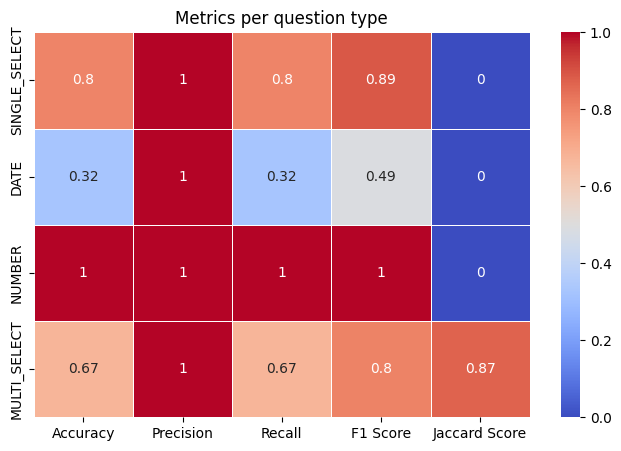

In [13]:
metrics, overall = predict_answers_regex(df_simple, qa_pipeline1)

print()
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics, overall)

### Predict answers for summarized DataFrame

DATE question processing failed: Unable to parse date from extracted time: early January
DATE question processing failed: unsupported operand type(s) for -: 'datetime.datetime' and 'NoneType'
Extracted time: two months, predicted date: 2025-03-09, intended date: 2025-03-09
Extracted time: before the 1st of next month, predicted date: 2025-02-09, intended date: 2025-02-09
DATE question processing failed: Unable to parse date from extracted time: by the end of the month
DATE question processing failed: unsupported operand type(s) for -: 'datetime.datetime' and 'NoneType'
DATE question processing failed: Unable to parse date from extracted time: end of the year
DATE question processing failed: Unable to parse date from extracted time: next Friday
DATE question processing failed: Unable to parse date from extracted time: month
DATE question processing failed: unsupported operand type(s) for -: 'datetime.datetime' and 'NoneType'
DATE question processing failed: Unable to parse date from ext

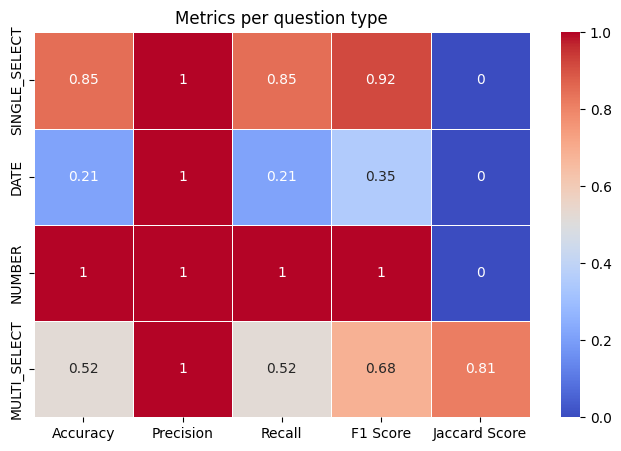

In [14]:
metrics, overall = predict_answers_regex(df, qa_pipeline1)

print()
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics, overall)